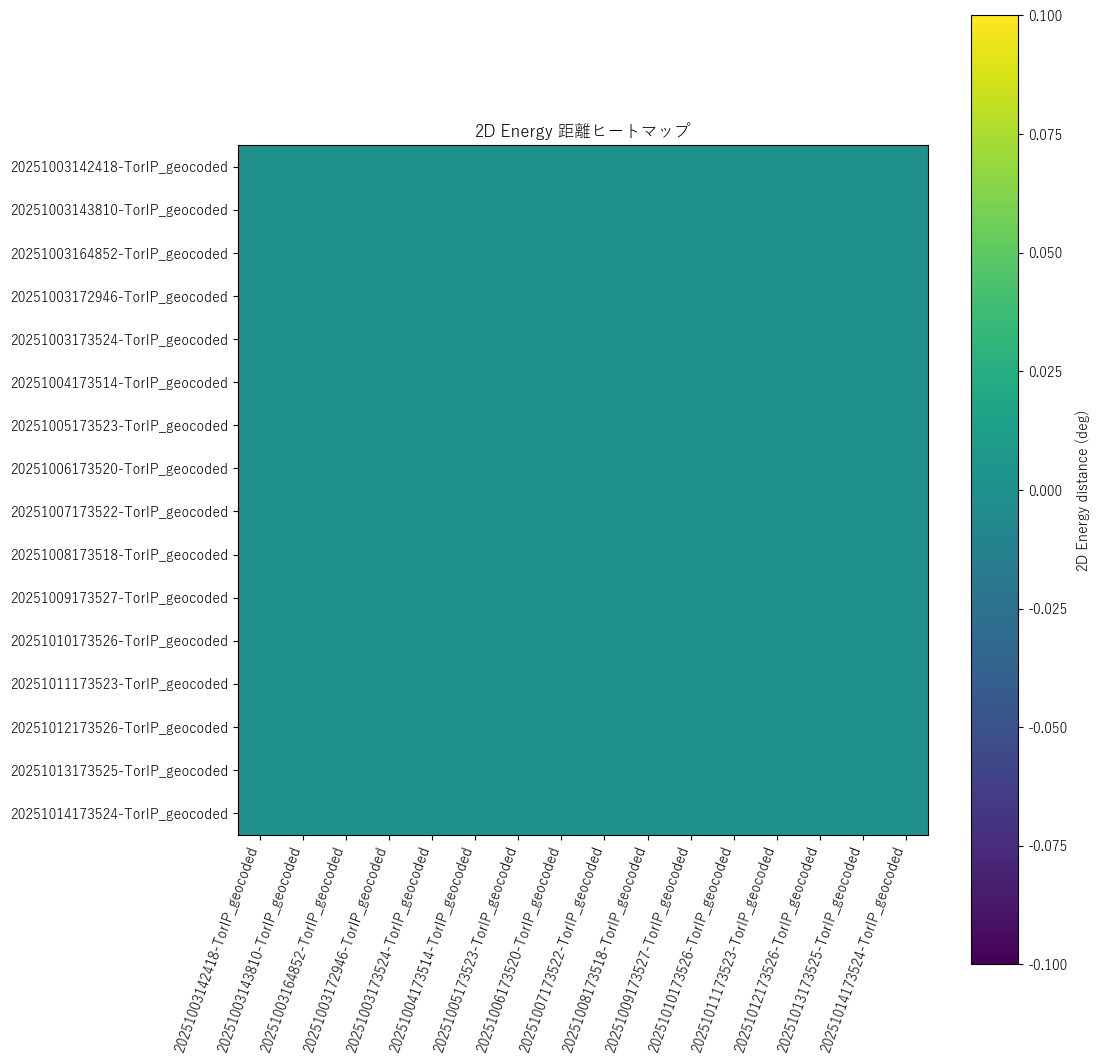

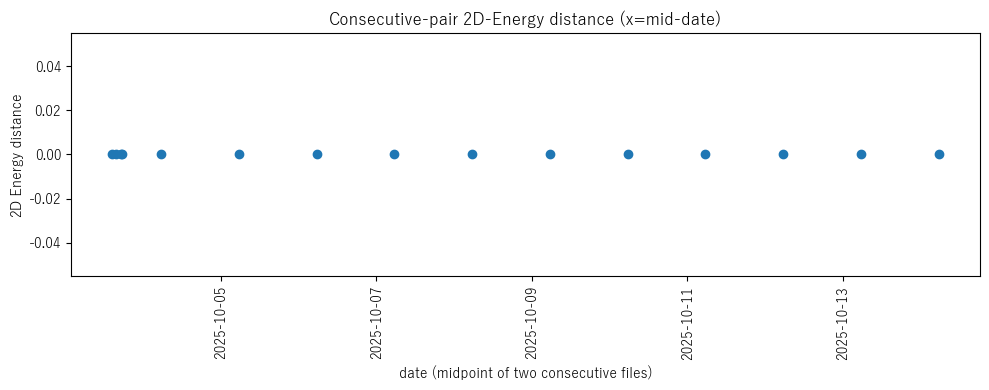

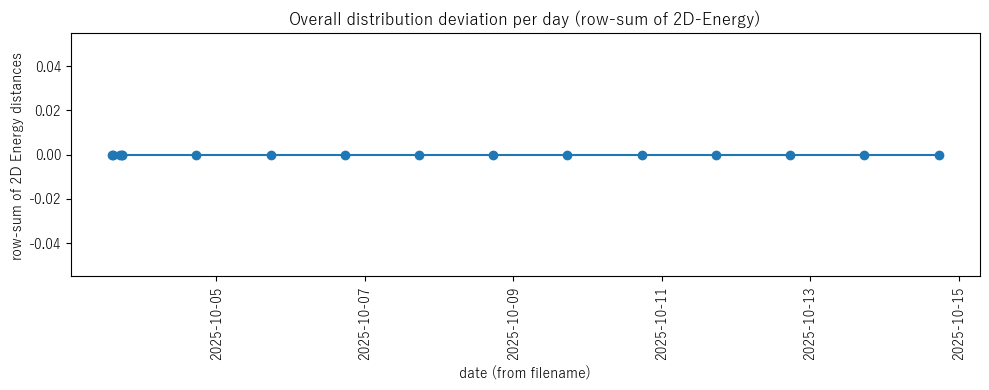

✅ 出力完了（Energy距離）
   energydist_matrix.csv
   energydist_files.txt
   energydist_timeseries.csv
   energydist_heatmap.png
   energydist_timeseries.png
   energydist_row_sums.png


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Energy 距離版
- isolation_forest.zip を自動解凍して *-TorIP_geocoded.csv を処理
- (1) 全ファイル間 2D-Energy 距離行列 (CSV/PNG)
- (2) 隣接ペア 2D-Energy 時系列 (CSV/PNG)
- (3) 距離行列の行総和（総乖離度）(PNG)

※ 1D Energy 距離:  E = 2E|X-Y| - E|X-X'| - E|Y-Y'|
   ・E|X-X'| は (2/(n(n-1))) * Σ_{i<j} |x_i - x_j|
   ・E|X-Y|   は (1/(nm)) * Σ_{i,j} |x_i - y_j|
   をソート＋累積和で厳密計算（O(n log n)）
※ 2D は lat と lon の 1D Energy 距離を RMS 合成
※ seaborn 不使用（matplotlib のみ）
"""

# ========= 設定 =========
ZIP_PATH        = "./isolation_forest.zip"
EXTRACT_DIR     = "./isolation_forest_extracted"
PREFIX          = "energydist"  # 出力プレフィックス
UNIT            = "deg"         # "deg" or "km"
MIN_ROWS        = 1
Z_THR_TS        = 3.5
OUTPUT_ENCODING = "cp932"       # Windowsで文字化けしにくい（UTF-8なら "utf-8-sig"）
# =======================

import os, sys, csv, math, zipfile, shutil
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib import font_manager, rcParams

# ---------- 日本語フォント（任意） ----------
JP_FONT_CANDIDATES = ["Yu Gothic", "Meiryo", "Noto Sans CJK JP", "IPAexGothic", "IPAPGothic", "TakaoGothic"]
def setup_japanese_font():
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in JP_FONT_CANDIDATES:
        if name in available:
            rcParams["font.family"] = "sans-serif"
            rcParams["font.sans-serif"] = [name]
            break
    rcParams["axes.unicode_minus"] = False

# ---------- 文字コード ----------
READ_ENCODINGS = ("utf-8", "utf-8-sig", "cp932", "iso-8859-1")
def open_read_fallback(path):
    last = None
    for enc in READ_ENCODINGS:
        try:
            return open(path, "r", encoding=enc, newline="")
        except Exception as e:
            last = e
    try:
        return open(path, "r", newline="")
    except Exception:
        raise last or RuntimeError(f"cannot open {path}")

TRANSLATE_TABLE = {
    0x2010: ord("-"), 0x2011: ord("-"), 0x2012: ord("-"), 0x2013: ord("-"),
    0x2014: ord("-"), 0x2015: ord("-"), 0x2212: ord("-"),
    0x00A0: ord(" ")
}
def normalize_text(s: str) -> str:
    return s.translate(TRANSLATE_TABLE) if isinstance(s, str) else s

def open_write(path):
    return open(path, "w", encoding=OUTPUT_ENCODING, newline="", errors="replace")

# ---------- CSV 読み込み ----------
def row_has_header_like(cells):
    if len(cells) < 4: return True
    try:
        float((cells[2] or "").strip()); float((cells[3] or "").strip())
        return False
    except Exception:
        return True

def load_valid_latlon(filepath):
    lats, lons = [], []
    with open_read_fallback(filepath) as f:
        rdr = csv.reader(f)
        first = next(rdr, None)
        if first is None: return np.empty(0), np.empty(0)
        use_header = row_has_header_like(first)
        rows_iter = rdr if use_header else [first] + list(rdr)
        for row in rows_iter:
            if len(row) < 4: continue
            a = (row[2] or "").strip(); b = (row[3] or "").strip()
            if not a or not b: continue
            try:
                lat = float(a); lon = float(b)
                if math.isfinite(lat) and math.isfinite(lon):
                    lats.append(lat); lons.append(lon)
            except Exception:
                continue
    return np.array(lats, float), np.array(lons, float)

# ---------- 単位換算 ----------
def deg_to_km_scale(lat_values):
    phi = (float(np.median(lat_values)) if len(lat_values) else 0.0) * math.pi/180.0
    return 111.32, 111.32 * math.cos(phi)

def convert_unit(lat_array, lon_array, ref_lat=None):
    if UNIT != "km":
        return lat_array, lon_array
    ref = ref_lat if ref_lat is not None else (np.median(lat_array) if len(lat_array) else 0.0)
    la_km, lo_km = deg_to_km_scale(np.array([ref]))
    return lat_array * la_km, lon_array * lo_km

# ---------- 1D: 平均絶対差の厳密計算（O(n log n)) ----------
def mean_abs_within(x_sorted):
    """
    E|X - X'| の標本推定量: (2/(n(n-1))) * Σ_{i<j} (x_j - x_i)
    ソート済み x_sorted を受け取り厳密に計算
    """
    n = x_sorted.size
    if n < 2: return 0.0
    # Σ_{i<j} (x_j - x_i) = Σ_k (2k - n - 1) * x_{(k)}, k=1..n（1始まり）
    k = np.arange(1, n+1, dtype=float)
    s = np.sum((2.0*k - n - 1.0) * x_sorted)
    return (2.0 / (n*(n-1))) * s

def mean_abs_cross(x, y):
    """
    E|X - Y| の標本推定量: (1/(nm)) * Σ_{i,j} |x_i - y_j|
    ソート＋prefix sum で厳密計算
    """
    n, m = x.size, y.size
    if n == 0 or m == 0: return 0.0
    xs = np.sort(x)
    ys = np.sort(y)
    csum = np.concatenate(([0.0], np.cumsum(ys)))  # len m+1
    # k_i = 個数 { y_j <= x_i }（side='right'にするなら <=/</=の扱いで好みで）
    k = np.searchsorted(ys, xs, side='left')
    sum_left  = csum[k]                 # Σ_{y<=x} y
    sum_total = csum[-1]
    # Σ_j |x - y_j| = x*k - sum_left + (sum_total - sum_left) - x*(m-k)
    contrib = xs * (2.0*k - m) + (sum_total - 2.0*sum_left)
    return float(np.sum(contrib) / (n * m))

def energy_distance_1d(x, y):
    """
    Energy distance（1D）: 2E|X-Y| - E|X-X'| - E|Y-Y'|  （>=0）
    """
    if x.size == 0 or y.size == 0: return 0.0
    mx = mean_abs_within(np.sort(x))
    my = mean_abs_within(np.sort(y))
    mxy = mean_abs_cross(x, y)
    e = 2.0 * mxy - mx - my
    return float(max(e, 0.0))

# ---------- 2D 合成 ----------
def composite_energy_distance_2d(lat_a, lon_a, lat_b, lon_b):
    ref_lat = np.median(np.concatenate([lat_a, lat_b])) if (len(lat_a)+len(lat_b)) else 0.0
    lat_a2, lon_a2 = convert_unit(lat_a, lon_a, ref_lat)
    lat_b2, lon_b2 = convert_unit(lat_b, lon_b, ref_lat)
    d_lat = energy_distance_1d(lat_a2, lat_b2)
    d_lon = energy_distance_1d(lon_a2, lon_b2)
    return float(np.hypot(d_lat, d_lon))

# ---------- ロバストZ ----------
def robust_zscore(x: np.ndarray) -> np.ndarray:
    if x.size == 0: return np.zeros(0, float)
    med = np.median(x); mad = np.median(np.abs(x - med))
    if mad == 0: return np.zeros_like(x, float)
    return 0.6745 * (x - med) / mad

# ---------- ファイル名日時 ----------
def date_from_filename(fname: str):
    base = os.path.basename(fname); key = base.split("-")[0]
    try:
        dt = datetime.strptime(key[:14], "%Y%m%d%H%M%S")
        return dt.date(), dt
    except Exception:
        return None

# ---------- メイン ----------
def main():
    setup_japanese_font()

    # zip 展開
    if os.path.exists(EXTRACT_DIR):
        shutil.rmtree(EXTRACT_DIR)
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    if not os.path.exists(ZIP_PATH):
        print(f"[ERROR] zipが見つかりません: {ZIP_PATH}", file=sys.stderr); return
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)

    # 対象CSV探索
    csv_files = []
    for root, _, files in os.walk(EXTRACT_DIR):
        for f in files:
            if f.endswith("TorIP_geocoded.csv"):
                csv_files.append(os.path.join(root, f))
    if len(csv_files) < 2:
        print("[ERROR] 有効CSVが2件未満です。", file=sys.stderr); return

    # 読み込み
    recs = []  # (day, dt_full, path, lats, lons)
    for f in sorted(csv_files):
        d = date_from_filename(f)
        if d is None:
            print(f"[WARN] 日付抽出に失敗: {f}", file=sys.stderr); continue
        day, dt_full = d
        lats, lons = load_valid_latlon(f)
        if len(lats) >= MIN_ROWS and len(lons) >= MIN_ROWS:
            recs.append((day, dt_full, f, lats, lons))
        else:
            print(f"[WARN] 有効行不足: {f}", file=sys.stderr)
    if len(recs) < 2:
        print("[ERROR] 有効データが2件未満です。", file=sys.stderr); return

    # 日時で整列
    recs.sort(key=lambda t: t[1])
    base_names = [os.path.splitext(os.path.basename(r[2]))[0] for r in recs]
    n = len(recs)

    # ---------- (1) 全ペア 2D-Energy 距離行列 ----------
    dist = np.zeros((n, n), float)
    for i in range(n):
        for j in range(i+1, n):
            la_i, lo_i = recs[i][3], recs[i][4]
            la_j, lo_j = recs[j][3], recs[j][4]
            d = composite_energy_distance_2d(la_i, lo_i, la_j, lo_j)
            dist[i, j] = dist[j, i] = d

    # 行列CSV（見出し付き）
    matrix_csv = f"{PREFIX}_matrix.csv"
    with open_write(matrix_csv) as w:
        wr = csv.writer(w)
        wr.writerow([""] + [normalize_text(nm) for nm in base_names])
        for i, nm in enumerate(base_names):
            wr.writerow([normalize_text(nm)] + [f"{x:.6f}" for x in dist[i]])

    # 行列のファイル順
    files_txt = f"{PREFIX}_files.txt"
    with open_write(files_txt) as w:
        w.write("\n".join(normalize_text(nm) for nm in base_names))

    # ヒートマップ
    fig = plt.figure(figsize=(max(6, n*0.7), max(5, n*0.7)))
    ax = plt.gca()
    im = ax.imshow(dist, aspect="equal", interpolation="nearest")
    cbar = plt.colorbar(im); cbar.set_label(f"2D Energy distance ({UNIT})")
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(base_names, rotation=70, ha="right")
    ax.set_yticklabels(base_names)
    ax.set_title("2D Energy 距離ヒートマップ")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_heatmap.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    # ---------- (2) 隣接ペア 時系列 ----------
    dt_full = [r[1] for r in recs]
    x_dates, dist_vals, file_pair = [], [], []
    for i in range(1, n):
        laL, loL = recs[i-1][3], recs[i-1][4]
        laR, loR = recs[i][3],  recs[i][4]
        d = composite_energy_distance_2d(laL, loL, laR, loR)
        dist_vals.append(d)
        mid = dt_full[i-1] + (dt_full[i] - dt_full[i-1]) / 2
        x_dates.append(mid)
        file_pair.append(f"{base_names[i-1]} -> {base_names[i]}")

    x_dates   = np.array(x_dates, dtype=object)
    dist_vals = np.array(dist_vals, float)
    z = robust_zscore(dist_vals)

    ts_csv = f"{PREFIX}_timeseries.csv"
    with open_write(ts_csv) as w:
        wr = csv.writer(w)
        wr.writerow(["date_mid","file_pair","distance_energy2d","z"])
        for i in range(len(dist_vals)):
            wr.writerow([
                x_dates[i].strftime("%Y-%m-%d %H:%M:%S"),
                normalize_text(file_pair[i]),
                f"{dist_vals[i]:{'.'}6f}",
                f"{z[i]:.3f}",
            ])

    fig = plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.plot(x_dates, dist_vals, marker="o", linestyle="none")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.xlabel("date (midpoint of two consecutive files)")
    plt.ylabel("2D Energy distance")
    plt.title("Consecutive-pair 2D-Energy distance (x=mid-date)")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_timeseries.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    # ---------- (3) 行総和 ----------
    row_sums = dist.sum(axis=1)
    dates_sorted = [r[1] for r in recs]
    fig = plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.plot(dates_sorted, row_sums, marker="o")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.xlabel("date (from filename)")
    plt.ylabel("row-sum of 2D Energy distances")
    plt.title("Overall distribution deviation per day (row-sum of 2D-Energy)")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_row_sums.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    print("✅ 出力完了（Energy距離）")
    print("  ", f"{PREFIX}_matrix.csv")
    print("  ", f"{PREFIX}_files.txt")
    print("  ", f"{PREFIX}_timeseries.csv")
    print("  ", f"{PREFIX}_heatmap.png")
    print("  ", f"{PREFIX}_timeseries.png")
    print("  ", f"{PREFIX}_row_sums.png")

if __name__ == "__main__":
    main()
